In [11]:
import numpy as np
import json
import seaborn as sns 
import pandas as pd 
from data import split_by_intent
import pathlib
from matplotlib import pyplot as plt 

In [19]:
def get_data_prob(intent_of_interest, checkpoint_dir, trigger_tokens, starts=False, equals=False):
    checkpoint_dir = pathlib.Path(checkpoint_dir)
    with open(checkpoint_dir.joinpath("data", "train.src_tok")) as src_f, open(checkpoint_dir.joinpath("data", "train.tgt")) as tgt_f:
        src_lines = [x.strip().split(" ") for x in src_f.readlines()]
        tgt_lines = [x.strip() for x in tgt_f.readlines()]

    count_output_has_fxn = 0
    count_input_has_trigger = 0
    count_output_has_fxn_and_input_has_trigger= 0
    for i, (src_l, tgt_l) in enumerate(zip(src_lines, tgt_lines)):
        has_trigger = False
        has_fxn = False 
        for tok in trigger_tokens:
            if not starts and not equals:
                if tok in [x.lower() for x in src_l]:
                    has_trigger = True
                    break
            elif equals and not starts:
                if " ".join(tok).lower() == " ".join(src_l).lower():
                    has_trigger = True
                    break
            else:
                if src_l[0].lower() == tok: 
                    has_trigger = True
                    break
        if intent_of_interest in [int(tgt_l)]:
            has_fxn = True
        if has_trigger:
            count_input_has_trigger += 1
        if has_trigger and has_fxn:
            count_output_has_fxn += 1
        if has_trigger and has_fxn:
            count_output_has_fxn_and_input_has_trigger += 1

        # if not has_fxn and has_trigger:
        #     print(" ".join(src_l))
        #     print(" ".join(tgt_l))


    prob_fxn_given_trigger = count_output_has_fxn_and_input_has_trigger / (count_input_has_trigger)
    prob_trigger_given_fxn = count_output_has_fxn_and_input_has_trigger / (count_output_has_fxn)

    return prob_fxn_given_trigger, prob_trigger_given_fxn


def get_model_prob(intent, checkpoint_dir):
    checkpoint_dir = pathlib.Path(checkpoint_dir)
    with open(checkpoint_dir.joinpath("test_predictions.json")) as f1:
        pred_data = json.load(f1) 
    model_probs = []
    for example in pred_data:
        if int(example['true']) == intent: 
            p_label = example['pred'][intent]
            model_probs.append(p_label)
    return np.mean(model_probs)

In [22]:

df = pd.DataFrame(columns=['seed', 'split', 'prob', 'type'], dtype=object)
for seed in [12, 31, 64]: 
# for seed in [12]: 
    for split in ["750", "1500", "3000", "7500", "15000", "18000"]:
        data_prob, __ = get_data_prob(50, f"/srv/local1/estengel/intent/50/{seed}_seed/{split}_15/", ["radio", "fm"], starts=False, equals=False)
        model_prob = get_model_prob(50, f"/srv/local1/estengel/intent/50/{seed}_seed/{split}_15/")

        df = df.append({"seed": seed, "split": split, "prob": data_prob, "type": "data"}, ignore_index=True)
        df = df.append({"seed": seed, "split": split, "prob": model_prob, "type": "model"}, ignore_index=True)
        





Text(0.5, 0, 'Total train')

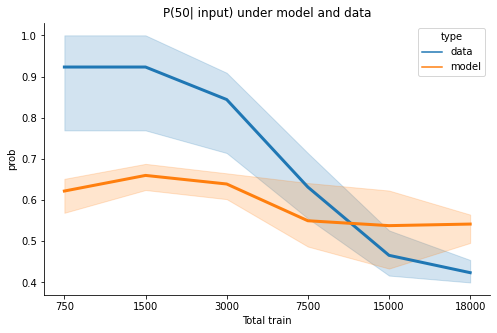

In [23]:

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df, x="split", y="prob", hue="type", linewidth=3)
sns.despine()
ax.set_title("P(50| input) under model and data")
ax.set_xlabel("Total train")

# plt.savefig("/home/t-eliass/papers/incremental_function_learning/figures/intent_50_prob_model_data.pdf")